In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import os, re, string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwordss = set(stopwords_list.decode().splitlines()) 

In [3]:
# !pip install wordcloud

In [4]:
data = pd.read_csv(r"C:\Users\user\OneDrive\Desktop\PCPP\data\kaggle project\train.csv")
test = pd.read_csv(r"C:\Users\user\OneDrive\Desktop\PCPP\data\kaggle project\test.csv")

# EDA
Exploring the datasets

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
data = data.fillna('N/A')
test = test.fillna('N/A')

In [10]:
data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [11]:
test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [12]:
data.shape

(7613, 5)

In [13]:
test.shape

(3263, 4)

Unique keywords in both train and test dataset

In [14]:
print (data.keyword.nunique(), test.keyword.nunique())

222 222


<AxesSubplot:xlabel='target', ylabel='count'>

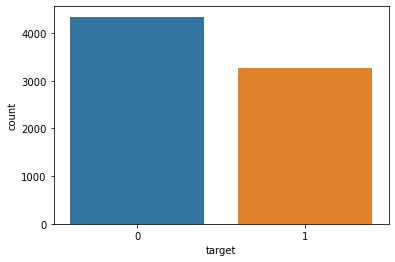

In [15]:
sns.countplot(x='target',data=data)

Text(0.5, 0, 'Text')

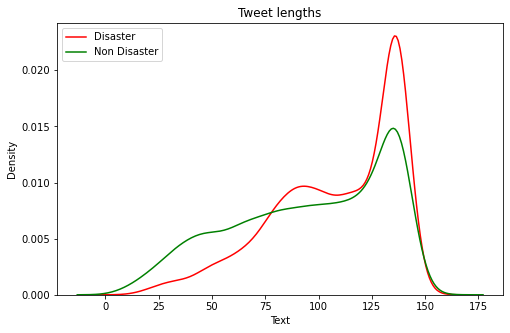

In [16]:
#comparing the tweets length of disaster and non disaster tweets
fig, ax = plt.subplots(figsize=(8,5)) 
disaster= data.loc[data.target==1].text.str.len()
non_disaster = data.loc[data.target==0].text.str.len()

sns.kdeplot(data=disaster.map(lambda x: np.mean(x)),color='red')
sns.kdeplot(data=non_disaster.map(lambda x: np.mean(x)),color='green')

plt.legend(labels=['Disaster', 'Non Disaster'])
plt.title("Tweet lengths")
plt.xlabel("Text")



Text(0.5, 0, 'Word')

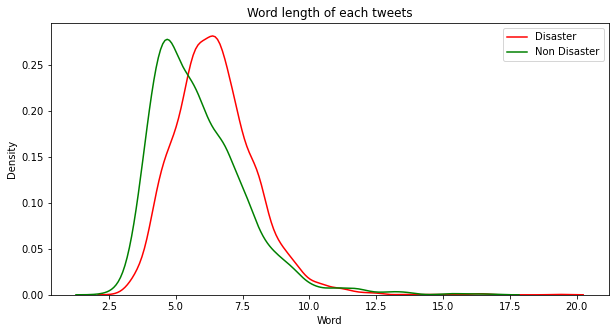

In [17]:
fig,ax=plt.subplots(figsize=(10,5))
disas=data[data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
nondisas=data[data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.kdeplot(data=disas.map(lambda x: np.mean(x)),color='red')
sns.kdeplot(data=nondisas.map(lambda x: np.mean(x)),color='green')
plt.legend(labels=['Disaster', 'Non Disaster'])
plt.title("Word length of each tweets")
plt.xlabel("Word")

In [18]:
def split_target(one_or_zero):
    splitted = [x for x in data[data['target']==one_or_zero]['text'].str.split()]
    return splitted

[Text(0.5, 1.0, 'Punctuation freq of Non Disaster Tweets')]

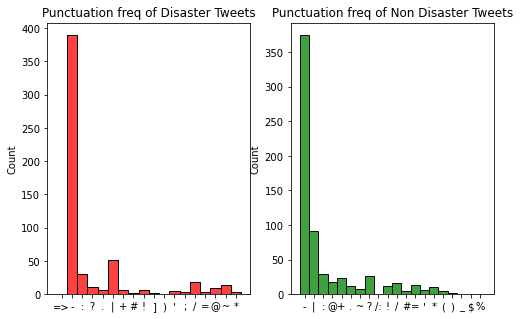

In [19]:
#check freq of punctuations in disasters tweets

puncs = string.punctuation

disas_puncs = []
for i in split_target(1):
    for x in i:
        if x in puncs:
            disas_puncs.append(x)
fig,(ax,ax1)=plt.subplots(1,2,figsize=(8,5))
sns.histplot(disas_puncs, color='red',ax=ax).set(title="Punctuation freq of Disaster Tweets")

non_disas_puncs = []
for i in split_target(0):
    for x in i:
        if x in puncs:
            non_disas_puncs.append(x)
sns.histplot(non_disas_puncs, color="green", ax=ax1).set(title="Punctuation freq of Non Disaster Tweets")

Could'nt find any relationship for punctuations in disaster and non disaster tweets

In [20]:
print(Counter(disas_puncs).most_common(7))
print(Counter(non_disas_puncs).most_common(7))

[('-', 389), ('|', 51), (':', 31), ('/', 18), ('~', 14), ('?', 11), ('@', 9)]
[('-', 374), ('|', 91), (':', 30), ('?', 26), ('+', 24), ('@', 18), ('/', 17)]


# Showing the common words used in disasters and non-disasters tweets

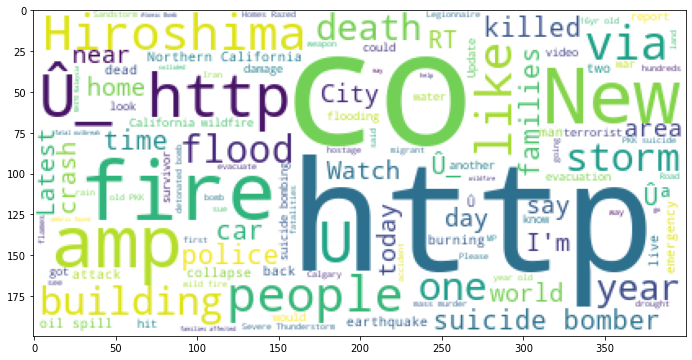

In [21]:
all_stopwords = set(stopwords.words("english"))
plt.figure(figsize=(12,6))
text = ' '.join(data.text[data['target']==1])

wc = WordCloud(background_color='white',stopwords=all_stopwords).generate(text)
plt.imshow(wc)

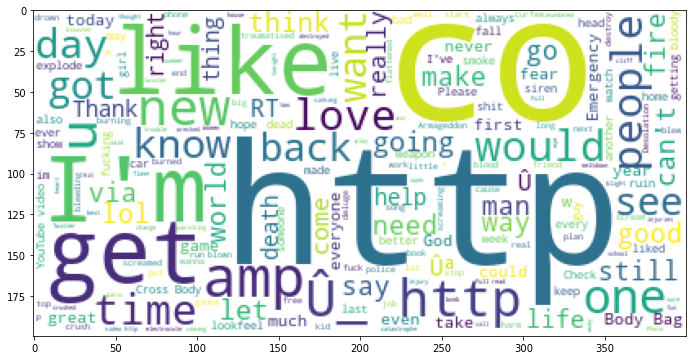

In [22]:
plt.figure(figsize=(12,6))
text = ' '.join(data.text[data['target']==0])

wc = WordCloud(background_color='white',stopwords=all_stopwords).generate(text)
plt.imshow(wc)

Spotted some characters that might not be caught with stopwords like 'û'

the text datas need further cleaning to see a clearer picture of common words

In [23]:
all_stopwords = stopwords.words("english")
all_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [24]:
test_processed = test.copy(deep=True)

In [26]:
"""Text Cleaning functions:
-make all text lowercase
-remove any words with [] brackets
-remove urls links
-remove punctuations and numbers
-remove any words that contains number
-remove any singular letters
-tokenize the text
-stemming the words
-join stemmed words back to strings"""

all_stopwords = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Define functions to clean and tokenizing the texts
""" tried lemmatization but gotten worst prediction"""
def custom_text_cleaning(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub( r"[^\sa-zA-Z]", "", text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in tokens if word not in all_stopwords]



    return ' '.join(stemmed)


In [27]:
train_df_processed = data.copy(deep=True)

In [28]:
#processing train's text data with pre-defined function to clean the text
train_df_processed['text'] = train_df_processed.text.apply(lambda x : custom_text_cleaning(x))
train_df_processed.head()

,id,keyword,location,text,target
0,1,N/A,N/A,deed reason earthquak may allah forgiv us,1
1,4,N/A,N/A,forest fire near la rong sask canada,1
2,5,N/A,N/A,resid ask shelter place notifi offic evacu she...,1
3,6,N/A,N/A,peopl receiv wildfir evacu order california,1
4,7,N/A,N/A,got sent photo rubi alaska smoke wildfir pour ...,1


stemming of words can reduce the word to basic form but also changed some word's spelling. However, the way they misspelled the words should be consistent, thus shouldnt cause problem.

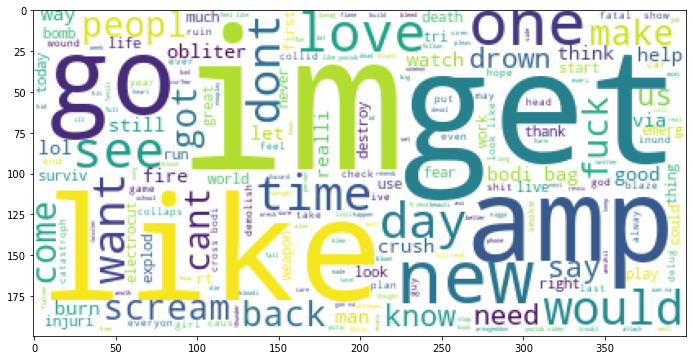

In [29]:
all_stopwords = set(stopwords.words("english"))
plt.figure(figsize=(12,6))
text_0 = ' '.join(train_df_processed.text[data['target']==0])

wc = WordCloud(background_color='white',stopwords=all_stopwords).generate(text_0)
plt.imshow(wc)

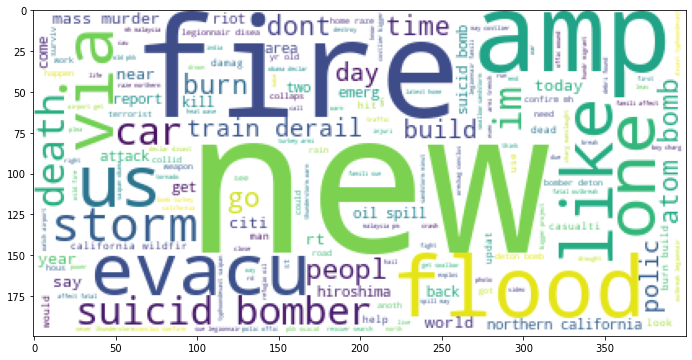

In [30]:
all_stopwords = set(stopwords.words("english"))
plt.figure(figsize=(12,6))
text_1 = ' '.join(train_df_processed.text[data['target']==1])

wc = WordCloud(background_color='white',stopwords=all_stopwords).generate(text_1)
plt.imshow(wc)

In [31]:
#common words at glance with word cloud
# idea is to remove common words in both disaster and non-disaster tweets to increase the difference

common = ['amp','peopl','day']
pat = r'\b(?:{})\b'.format('|'.join(common))
train_df_processed['new'] = train_df_processed.text.str.replace(pat, '')



C:\Users\user\AppData\Local\Temp/ipykernel_37556/4087893346.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df_processed['new'] = train_df_processed.text.str.replace(pat, '')


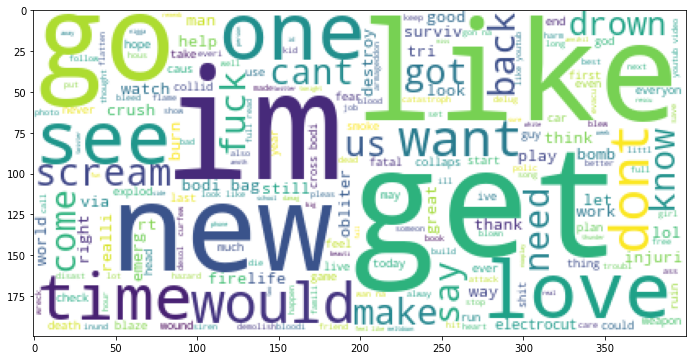

In [32]:
plt.figure(figsize=(12,6))
text_0 = ' '.join(train_df_processed.new[data['target']==0])

wc = WordCloud(background_color='white',stopwords=all_stopwords).generate(text_0)
plt.imshow(wc)

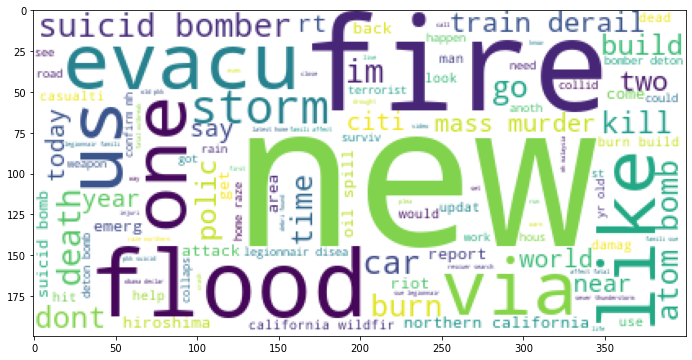

In [33]:
plt.figure(figsize=(12,6))
text_1 = ' '.join(train_df_processed.new[data['target']==1])

wc = WordCloud(background_color='white',stopwords=all_stopwords).generate(text_1)
plt.imshow(wc)

In [34]:
import collections 

"""non disaster"""
counter = collections.Counter(text_0.split())
print(counter.most_common(50))

[('like', 307), ('im', 248), ('get', 223), ('new', 170), ('dont', 154), ('go', 142), ('one', 136), ('love', 117), ('bodi', 117), ('bag', 111), ('time', 106), ('via', 99), ('want', 98), ('see', 98), ('make', 98), ('would', 97), ('scream', 97), ('video', 96), ('burn', 92), ('know', 91), ('got', 91), ('look', 90), ('fire', 90), ('let', 89), ('come', 88), ('cant', 86), ('us', 86), ('back', 86), ('emerg', 84), ('wreck', 83), ('full', 82), ('think', 81), ('obliter', 79), ('fuck', 77), ('feel', 77), ('youtub', 76), ('say', 76), ('work', 72), ('still', 72), ('need', 72), ('world', 72), ('drown', 72), ('good', 68), ('take', 67), ('year', 64), ('man', 63), ('na', 62), ('lol', 61), ('explod', 61), ('rt', 60)]


In [35]:
"""disaster"""
counter = collections.Counter(text_1.split())
print(counter.most_common(50))

[('fire', 269), ('bomb', 182), ('kill', 159), ('news', 140), ('via', 121), ('flood', 120), ('disast', 118), ('california', 115), ('crash', 113), ('suicid', 110), ('train', 109), ('polic', 106), ('famili', 105), ('attack', 104), ('evacu', 101), ('like', 101), ('home', 100), ('build', 97), ('storm', 92), ('hiroshima', 90), ('fatal', 90), ('pm', 89), ('get', 88), ('derail', 88), ('year', 86), ('burn', 85), ('us', 84), ('wildfir', 80), ('emerg', 79), ('live', 73), ('car', 73), ('two', 72), ('accid', 72), ('mh', 72), ('time', 71), ('nuclear', 71), ('video', 71), ('one', 69), ('collaps', 69), ('say', 67), ('death', 66), ('murder', 65), ('report', 64), ('northern', 64), ('caus', 63), ('dead', 63), ('legionnair', 62), ('watch', 61), ('war', 61), ('bomber', 61)]


In [36]:
X = train_df_processed.loc[:,'text']
y = train_df_processed.loc[:,'target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [37]:
# using TF-IDF to vectorize the words after removing stop words
# the more a words appears the higher the weightage
tfidf = TfidfVectorizer(min_df=5, max_df=0.7,ngram_range = (1,2))
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)

In [38]:
test_processed = test.copy(deep=True)

In [39]:
#processing train's text data with pre-defined function to clean the text
test_processed['text'] = test_processed['text'].apply(lambda x : custom_text_cleaning(x))
# common = ['amp','peopl','day']
# pat = r'\b(?:{})\b'.format('|'.join(common))
# train_df_processed['new'] = test_processed.text.str.replace(pat, '')
test_processed.head()

,id,keyword,location,text
0,0,N/A,N/A,happen terribl car crash
1,2,N/A,N/A,heard earthquak differ citi stay safe everyon
2,3,N/A,N/A,forest fire spot pond gees flee across street ...
3,9,N/A,N/A,apocalyps light spokan wildfir
4,11,N/A,N/A,typhoon soudelor kill china taiwan


In [40]:
real_tfidf=tfidf.transform(test_processed["text"])
real_tfidf

<3263x2502 sparse matrix of type '<class 'numpy.float64'>'
	with 23341 stored elements in Compressed Sparse Row format>

In [41]:
print(train_tfidf.shape)
print(test_tfidf.shape)

(5329, 2502)
(2284, 2502)


In [42]:
"""Testing the results with multiple Models"""

models = []

models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
                                max_depth=10, random_state=0, max_features=None)
models.append(("RandomForest2",rf2))

"""cross validation score to see which model performs the best"""

results = []
names = []
for name,model in models:
    result = cross_val_score(model, train_tfidf, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

print()

for i in range(len(names)):
    print(names[i],results[i])


LogisticRegression 0.7885142106090334
SVC 0.7915164742683031
LinearSVC 0.765997602836376
KNeighbors 0.6637228111623159
DecisionTree 0.728278609222616
RandomForest 0.7774415876202596
RandomForest2 0.6864315426850599

LogisticRegression [0.79628588 0.79560811 0.77364865]
SVC [0.8002251  0.79617117 0.77815315]
LinearSVC [0.76477209 0.77195946 0.76126126]
KNeighbors [0.68486213 0.63288288 0.67342342]
DecisionTree [0.73157006 0.72240991 0.73085586]
RandomForest [0.79122116 0.77421171 0.76689189]
RandomForest2 [0.69274057 0.68412162 0.68243243]


In [43]:
"""Choosing SVC Model as it seems to perform the best out of all the above models chosen"""
SVC = SVC()
SVC.fit(train_tfidf, y_train)

# Output the class values
preds = SVC.predict(test_tfidf)
#logreg_pred_test = logreg.fit(test_tfidf)

print(preds)

[0 0 1 ... 1 1 0]


In [44]:
log_reg = LogisticRegression()
log_reg.fit(train_tfidf, y_train)

preds2 = log_reg.predict(test_tfidf)
print(preds2)

[0 0 1 ... 1 1 0]


In [45]:
print(SVC.score(test_tfidf, y_test)) 
print(metrics.precision_score(y_test, preds))
print(metrics.recall_score(y_test, preds))
print(metrics.r2_score(y_test, preds))

0.8051663747810858
0.8293299620733249
0.6790890269151139
0.20170469718533335


In [46]:
print(log_reg.score(test_tfidf, y_test)) 
print(metrics.precision_score(y_test, preds2))
print(metrics.recall_score(y_test, preds2))
print(metrics.r2_score(y_test, preds2))

0.8042907180385289
0.8168498168498168
0.6925465838509317
0.1981168531277393


In [47]:
#predictions for the test dataset
real_preds=SVC.predict(real_tfidf)
real_preds

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [50]:
# """generate csv file for kaggle submission"""
output_dataframe = pd.DataFrame({
    'Id': test_processed['id'],
    'target': real_preds
})
output_dataframe.to_csv('pred_ini.csv', index=False) 

# Conclusion

In [49]:
"""Overall the text column of the train data plays has a major relation in predicting whether the tweets are real disaster tweets
As we had purely focused on the text column and had gotten 0.79 prediction accuracy in kaggle.
Improvements on mining of text in the text columns that could be done:
Our text cleaning method was more of a catch-all kind
-make all text lowercase
-remove any words with [] brackets
-remove urls links
-remove punctuations and numbers
-remove any words that contains number
-remove any singular letters

 there are some cleaning methods that could filter away important words that could have given more insights.
 such as the @ and # punctuations, as tweets uses @ to tag people or organisations and # to provide keywords to increase
 the rate people can view their tweets.
 Given more time, we could find the most common @ and # of disaster and non-disaster tweets, make them into features
 by vectorising the words.
 removing punctuation could also make some words have less meaning such as I've should'nt could've, removing the punctuation
 would make these words would result it words losing their meaning.
 
 There were also some spelling errors in the text that could be corrected, have tried using the spellchecker module, able to
 correct the spellings but causes the code to run very long, thus decided to remove it instead.
 Found another library called symspellpy that seems to be faster and provide a better correction, it could seperate words
 that were misstyped together like "thetotal" to "the total","could've" to "could have" and checking the spellings.
 Would try to use it in the future to see if it improve the score of the prediction.

In addition, we do believe that keywords could also improve the prediction as it focus on the KEYWORDS of the text and it only had 
61 null values out of the 7613 rows of the date.
Logically keywords that appear more frequently in disaster tweets should provided a better prediction of whether a tweet is 
disaster tweets in the future.

Location column wise, we feel that the amount of null values is pretty big, thus we didnt do further exploration of the data.

"""

'Overall the text column of the train data plays has a major relation in predicting whether the tweets are real disaster tweets\nAs we had purely focused on the text column and had gotten 0.79 prediction accuracy in kaggle.\nImprovements on mining of text in the text columns that could be done:\nOur text cleaning method was more of a catch-all kind\n-make all text lowercase\n-remove any words with [] brackets\n-remove urls links\n-remove punctuations and numbers\n-remove any words that contains number\n-remove any singular letters\n\n there are some cleaning methods that could filter away important words that could have given more insights.\n such as the @ and # punctuations, as tweets uses @ to tag people or organisations and # to provide keywords to increase\n the rate people can view their tweets.\n Given more time, we could find the most common @ and # of disaster and non-disaster tweets, make them into features\n by vectorising the words.\n removing punctuation could also make som